### Importación de librerías

In [1]:
# Librerías generales
from IPython.core.display import display, HTML
import json
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.max_columns', 50)

# Librerías ML
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
hierarchy.set_link_color_palette(['b', 'r', 'm', 'c'])

# Gráficos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import style
style.use("ggplot")
plt.rcParams["figure.figsize"] = [12,9]
colors = 12*['r','g','b','c','k','y','m']


### Ocultar código

In [20]:
# Ejecutar esta celda para ocultar el código
Ocultar_Codigo = False
display(HTML('<script> code_show='+str(Ocultar_Codigo).lower()+'; function code_toggle()'+
             '{ if (code_show){ $("div.input").hide(); }'
             'else { $("div.input").show(); } code_show = !code_show} ' +
             '$( document ).ready(code_toggle);'+
             '</script><center><form action="javascript:code_toggle()">'+
             '<input type="submit" value="Mostrar/Ocultar el codigo"></form></center>'))

## Resultados

In [21]:
# Visualización de resultados
# Esta celda muestra en una tabla los resultados guardados de ejecuciones anteriores.
nombre_fichero_resultados = "./numeroCusters.json"

# Diccionario de Experimentos
expDic = {"T": "Matriz de transiciones",
          "T-PCA": "Matriz de transiciones con PCA",
          "T-PCAG": "Matriz de transiciones con PCA genérico",
          "F": "Matriz de frencuencias",
          "F-PCA": "Matriz de frecuencias con PCA",
          "F-PCAG": "Matriz de frecuencias con PCA genérico"
         }
# Si no hay ningún documento, no muestra nada.
try:
    html = ""
    cabecera = "<center><table style='width:40%'><tr><th>Dimensión/Semana</th>"+\
                "<th>1</th><th>2</th><th>3</th><th>4</th><th>5</th><th>6</th></tr>"
    showdic = {}
    
    # Lee el fichero con los resultados de los experimentos
    with open(nombre_fichero_resultados, "r") as fr:
        for line in fr:
            data_in = json.loads(line)
            code = data_in["Nombre"]
            code = code.split("@")
            # code[0]: nombre del experimento
            # code[1]: dimensión de los vectores de características.
            
            datalist = [int(code[1])]
            datalist.append(data_in["nClusters"])
            try:
                showdic[str(code[0])].append(datalist)
            except:
                showdic[str(code[0])] = [datalist]
    fr.close()
    
    tipos = sorted(showdic)
    
    # Iteramos por tipos de experimentos
    for typ in tipos:
        entries = showdic[typ]
        entries = sorted(entries, key=lambda e: e[:][0])
        html += "<h3>"+expDic[typ]+"</h3><p>"
        html += cabecera
        
        # Número de registros por tabla
        for poslist in range(0,len(entries)):
            html += "<tr><th>"+"%d"%entries[poslist][0]+"</th>"
            
            #Número de clusters por semana
            for cl in entries[poslist][1]:
                html += "<td>"+"%d"%cl+"</td>"    
            html +="</tr>"
        html += "</table></center><p><p>"
        
    # Mostramos las tablas HTML
    display(HTML(html))
except:
    print "No hay resultados que mostrar."

Dimensión/Semana,1,2,3,4,5,6
49,8,172,161,185,297,446
Dimensión/Semana,1,2,3,4,5,6
2,3,7,8,10,16,22
8,5,44,37,56,110,175
16,8,103,94,134,232,377
Dimensión/Semana,1,2,3,4,5,6
49,329,651,671,612,594,569
Dimensión/Semana,1,2,3,4,5,6
2,25,42,46,48,56,82
8,192,409,442,427,446,410


<a name="T1"></a>
## Tarea 1: Conversión de matrices de transición a vectores de características

Este script transforma las matrices de transiciones a vectores de características, las cuales tienen la siguiente forma:

    n_semana x n_instancia x n_atributo

Además, el uso de matrices de frencuencias en vez de matrices de transiciones se puede cambiar modificando el parámetro *Use_freq*.

--

- [Inicio](#Inicio)
- [Tarea 2: Filtrado y transformación de características](#T2)
- [Tarea 3: Reducción de dimensionalidad con PCA](#T3)
- [Tarea 4: Clustering jerárquico: representación del dendrograma](#T4)
- [Tarea 5: Aplicación de MeanShift para la estimación de clusters](#T5)


### *Variables*: uso de matrices de frecuencias y nombre del fichero de entrada 
- *Use_frec*: si está a true usa matrices de frecuencias, si no usa matrices de transiciones.
- *infile_name*: nombre del fichero con las matrices de transiciones.

In [22]:
Use_freq = True
infile_name = './brick_freq.json'

In [23]:
# Se genera un vector de usuarios y una matriz de tamaño n_usuarios x n_atributos (49) por semana.
Usuarios = []
Features = [[],[],[],[],[],[]]

# Fichero de entrada
with open(infile_name, "r") as infile:
    
    # Cada línea del fichero de entrada es un usuario diferente.
    for line in infile:
        data_in = json.loads(line)
        
        # Almacenamos los usuarios
        Usuarios.append(data_in["Usuario"])
        
        # Creamos una lista de vectores de características, de tamaño n_semanas x n_atributos
        feat_ini = [[0]*49,[0]*49,[0]*49,[0]*49,[0]*49,[0]*49]
        
        # Iteramos sobre las matrices de características de las cuales tenemos datos.
        for caract in data_in["Caracteristicas"]:
            semana = int(caract["s"])
            features = []
            
            # Extendemos la matriz de transiciones a un vectores de características.
            for row in caract["tm"]:
                features.extend(row)
            
            # Si queremos usar tablas de frecuencias, normalizamos entre el número de transiciones por semana
            if Use_freq:
                features =  [x / float(caract["nt"]) for x in features]
                
            # Almacenamos en la lista de vectores de caracterísitcas
            feat_ini[semana-1] = features
            
        # Almacenamos en la matriz de características
        for j in range(0,6):
            Features[j].append(feat_ini[j])
            

In [24]:
# Muestra los vectores de características y los usuarios.
# No es recomendable utilizar con grandes cantidades de datos.
# deprecated!

def printFeatures(Usuarios, Features):
    for s in range(0, len(Features)):
        print
        print "SEMANA ", s+1
        print
        for u in range(0,len(Usuarios)):
            print Usuarios[u] + "[",
            for f in range(0,len(Features[s][u])):
                print str(Features[s][u][f]),
            print "]"

<a name="T2"></a>
## Tarea 2: Filtrado y transformación de características

En este script se filtran las características a utilizar con el fin de mejorar el clustering.

--

- [Inicio](#Inicio)
- [Tarea 1: Conversión de matrices de transición a vectores de características](#T1)
- [Tarea 3: Reducción de dimensionalidad con PCA](#T3)
- [Tarea 4: Clustering jerárquico: representación del dendrograma](#T4)
- [Tarea 5: Aplicación de MeanShift para la estimación de clusters](#T5)


Aquí se pueden aplicar transformaciones relacionadas con el filtrado de datos.

<a name="T3"></a>
## Tarea 3: Reducción de dimensionalidad con PCA

En este script se reduce la dimensionalidad usando PCA.
Se puede variar si se quiere o no realizar PCA, la dimensión a la que se quiere transformar y si se quiere usar un PCA genérico (con los datos de todas las semanas).

--

- [Inicio](#Inicio)
- [Tarea 1: Conversión de matrices de transición a vectores de características](#T1)
- [Tarea 2: Filtrado y transformación de características](#T2)
- [Tarea 4: Clustering jerárquico: representación del dendrograma](#T3)
- [Tarea 5: Aplicación de MeanShift para la estimación de clusters](#T5)


### *Variables*: Uso de PCA, PCA genérico, dimensión a transformar y características
- *Use_PCA*: si está a True se aplica PCA, si no, no se aplica
- *Use_generic_PCA*: si está a True se aplica un PCA genérico de todas las semanas.
- *dimPCA*: dimensión del PCA.
- *feat*: nombre de las características de entrada a utilizar.

In [66]:
Use_PCA = True
Use_generic_PCA = False
dimPCA = 2
feat = Features

In [80]:
# Si no se quiere usar PCA, salimos,
if Use_PCA == False:
    pcaFeatures = Features
    
    print "No se ha aplicado PCA."
    
# Si se quiere usar PCA Genérico, creamos una tabla de datos de todas las semanas
elif Use_generic_PCA:
    
    pca = PCA(dimPCA)
    genericFeatures = []
    pcaFeatures = []
    
    for sem in range(0,len(feat)):
        genericFeatures.extend(feat[sem])
    
    # Entrenamos el PCA
    pca.fit(genericFeatures)
    
    # Aplicamos PCA
    for sem in range(0,len(feat)):
        pcaFeatures.append(pca.transform(feat[sem]))
        
    # Mostramos las componentes
    print "Componentes:"
    print pca.components_
    print
    print "Aplicado PCA genérico con reducción de dimensionalidad a " + "%d"%(dimPCA) + "."

# Si se quiere usar PCA por semana
else:
    pca = PCA(dimPCA)
    pcaFeatures = []
    print "Componentes:"
    
    # Entrenamos y aplicamos PCA
    for sem in range(0,len(feat)):        
        pcaFeatures.append(pca.fit_transform(feat[sem]))
        
        # Mostramos las componentes
        print "Semana",sem+1
        print pca.components_

    print    
    print "Aplicado PCA por semanas con reducción de dimensionalidad a " + "%d"%(dimPCA) +"."

Componentes:
Semana 1
[[-1. -0.]
 [-0. -1.]]
Semana 2
[[ 1.  0.]
 [-0. -1.]]
Semana 3
[[-1. -0.]
 [ 0.  1.]]
Semana 4
[[  1.00000000e+00   1.13188371e-13]
 [  1.13188371e-13  -1.00000000e+00]]
Semana 5
[[ 1.  0.]
 [-0. -1.]]
Semana 6
[[ 1.  0.]
 [-0. -1.]]
Aplicado PCA por semanas con reducción de dimensionalidad a 2.


<a name="T4"></a>
## Tarea 4: Clustering jerárquico: representación del dendrograma

En este script se realiza un clustering jerárquico y se muestra el dendrograma resultante sobre las nuevas características (las transformadas).
El número de subclusters que se representa en el dendrograma es parametrizable.
Puede cancelarse la representación poniendo la variable *Show_denro* a *False*.

--

- [Inicio](#Inicio)
- [Tarea 1: Conversión de matrices de transición a vectores de características](#T1)
- [Tarea 2: Filtrado y transformación de características](#T2)
- [Tarea 3: Reducción de dimensionalidad con PCA](#T3)
- [Tarea 5: Aplicación de MeanShift para la estimación de clusters](#T5)


### *Variables*: profundidad de clusters a representar en el dendrograma y flag de representación, características
- *Show_dendro*: si está a True muestra los dendrogramas por semana.
- *dendro_depth*: profundidad del dendrograma. Valor máximo recomendado 150.
- *feat*: características a utilizar para mostrar el dendrograma

In [68]:
Show_denro = False
dendro_depth = 50
feat = pcaFeatures

In [69]:
# Clustering jerárquico y representación de los dendrogramas
if Show_denro:
    for sem in range(0,len(feat)):
        Z = hierarchy.linkage(feat[sem], 'complete', metric='euclidean')
        
        # Representación de los dendrogramas
        dn2 = hierarchy.dendrogram(Z, dendro_depth, 'lastp', above_threshold_color='k', orientation='right')
        plt.title("Dendrograma Semana " + str(sem+1))
        plt.xlabel("Distancia")
        plt.ylabel("Clusters")
        plt.show()

<a name="T5"></a>
## Tarea 5: Aplicación de MeanShift para la estimación de clusters

En este script estima el número de clusters utilizando el algoritmo MeanShift, que busca máximos locales en los datos.
Se pueden representar los clusters encontrados de baja dimensionalidad.

Los datos se guardan en un fichero JSON que se carga al inicio de este documento.
--

- [Inicio](#Inicio)
- [Tarea 1: Conversión de matrices de transición a vectores de características](#T1)
- [Tarea 2: Filtrado y Transformación de Características](#T2)
- [Tarea 3: Reducción de dimensionalidad con PCA](#T3)
- [Tarea 4: Clustering jerárquico: representación del dendrograma](#T4)


### *Variables*: flag de guardar en fichero, nombre del fichero, código del experimento, flag de representación y características
- *Guardar_fichero*: si está a True, guarda el resultado del experimento en un fichero JSON.
- *nombre_fichero_guardar*: nombre del fichero donde guardar los datos del experimento.
- *Show_MSCLuesters*: si está a True y la dimensión lo permite, muestra una representación de los clusters.
- *feat*: características a utilizar para usar MeanShift.
- *codigo_experimento*: nombre codificado del experimento a relizar.

In [70]:
Guardar_fichero = False
nombre_fichero_guardar = "./numeroCusters.json"
Show_MSClusters = True
feat = pcaFeatures

codigo_experimento = ("F" if Use_freq else "T") +\
    ("-PCA" if Use_PCA else "") + ("G" if Use_generic_PCA else "") + \
    "@" + "%d"%(len(feat[0][0]))
    

In [71]:
# Muestra el nombre del experimento
display(HTML("<center><h1><font color='blue'>"+codigo_experimento+"</font></h1></center>"))

Semana 1
Número estimado de clusters: 3


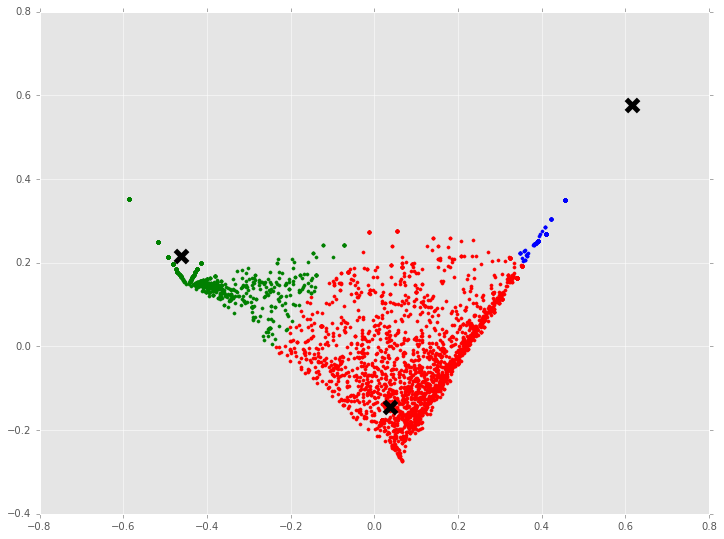

[[  3.78496955e-01   1.14656068e-02   5.34843614e-03   1.66952133e-04
    2.50471973e-03   1.37676641e-03   9.05743757e-01   8.63292381e-03
    1.75968380e-02  -4.62290198e-05  -6.68924455e-06  -4.61028644e-05
    7.34218712e-05   6.43745320e-03   3.19375885e-03   5.00137737e-04
    7.39547347e-03   2.71141247e-06  -1.16270146e-04  -1.09733746e-04
    4.88801243e-03   6.14217302e-04   4.41421202e-05   5.52657227e-06
   -1.92203096e-04  -4.13090607e-06   1.86516333e-05   1.52322438e-03
    1.14338110e-02   2.20376131e-05  -1.41848795e-04   1.13762762e-05
   -1.33860850e-02   3.54362700e-06  -1.52751239e-02   1.07432217e-03
    7.47867300e-05   5.71488735e-05   2.94599832e-04   1.42128851e-05
    1.48932724e-03   2.60394047e-03   1.87263630e-01   4.17827033e-03
    4.46177037e-03   3.64321177e-03   1.18301960e-03   3.06429967e-03
    0.00000000e+00]
 [  2.34168742e-02  -7.21820169e-03  -4.63254843e-03  -9.59818370e-05
    9.36047475e-03  -6.85174581e-05   8.42299990e-03  -5.01327372e-03


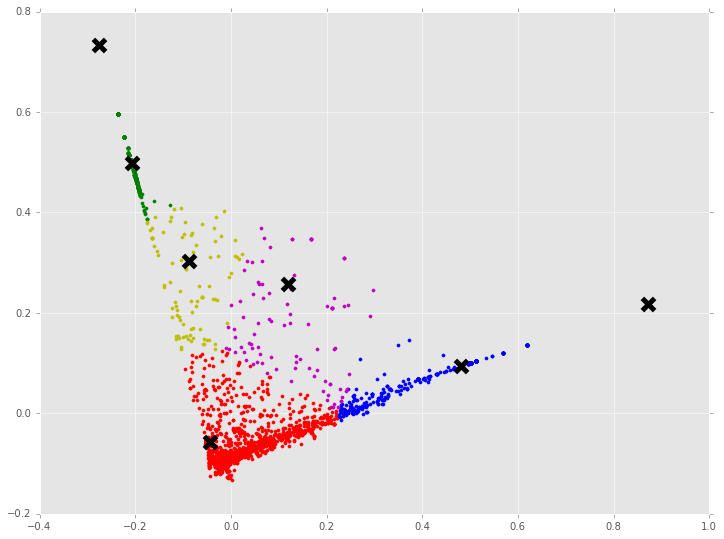

[[  3.78496955e-01   1.14656068e-02   5.34843614e-03   1.66952133e-04
    2.50471973e-03   1.37676641e-03   9.05743757e-01   8.63292381e-03
    1.75968380e-02  -4.62290198e-05  -6.68924455e-06  -4.61028644e-05
    7.34218712e-05   6.43745320e-03   3.19375885e-03   5.00137737e-04
    7.39547347e-03   2.71141247e-06  -1.16270146e-04  -1.09733746e-04
    4.88801243e-03   6.14217302e-04   4.41421202e-05   5.52657227e-06
   -1.92203096e-04  -4.13090607e-06   1.86516333e-05   1.52322438e-03
    1.14338110e-02   2.20376131e-05  -1.41848795e-04   1.13762762e-05
   -1.33860850e-02   3.54362700e-06  -1.52751239e-02   1.07432217e-03
    7.47867300e-05   5.71488735e-05   2.94599832e-04   1.42128851e-05
    1.48932724e-03   2.60394047e-03   1.87263630e-01   4.17827033e-03
    4.46177037e-03   3.64321177e-03   1.18301960e-03   3.06429967e-03
    0.00000000e+00]
 [  2.34168742e-02  -7.21820169e-03  -4.63254843e-03  -9.59818370e-05
    9.36047475e-03  -6.85174581e-05   8.42299990e-03  -5.01327372e-03


KeyboardInterrupt: 

In [79]:
# Si se quiere guardar el experimento, creamos un diccionario para el experimento.
if Guardar_fichero:
    Expdic = {
        "Nombre": codigo_experimento,
        "nClusters": []}

# Creamos un MeanShift
ms = MeanShift()

# Iteramos por semana
for sem in range(0,len(feat)):
    print "Semana",sem+1
    
    # Ajustamos las características
    ms.fit(feat[sem])
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters = len(np.unique(labels))
    print "Número estimado de clusters:", n_clusters
    
    # Si queremos guardar el experimento, añadimos a la lista de clusters
    if Guardar_fichero:
        Expdic["nClusters"].append(n_clusters)
    
    # Si queremos mostrar y la dimensionalidad lo permite, representamos.
    if Show_MSClusters:
        
        # Representación en 2D
        if len(feat[sem][0]) == 2:
            X=feat[sem]
            for i in range(0, n_clusters):
                plt.scatter(X[labels==i,0], X[labels==i,1], color=colors[i], s=10, zorder=10)
            plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
                        marker="x",color='k', s=150, linewidths = 5, zorder=10)
            plt.show()
            
        # Representación en 3D
        elif len(feat[sem][0]) == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            X=feat[sem]
            for i in range(0, n_clusters):
                ax.scatter(X[labels==i,0], X[labels==i,1], X[labels==i,2], color=colors[i], s=10, zorder=10)
            ax.scatter(cluster_centers[:,0],cluster_centers[:,1], cluster_centers[:,2],
                        marker="x", color='k', s=150, linewidths = 5, zorder=10)
            plt.show()
    print

In [76]:
# Si queremos guardar en el fichero
if Guardar_fichero:
    savedic = {}
    # Si existe, escribimos a continuación
    try:
        with open(nombre_fichero_guardar,"r") as fg:
            for line in fg:
                data_in = json.loads(line)
                savedic[data_in["Nombre"]] = data_in["nClusters"]
        fg.close()
    except:
        print "Creando fichero nuevo... "
        
    savedic[Expdic["Nombre"]] = Expdic["nClusters"]
    
    # Guardamos en el fichero
    with open(nombre_fichero_guardar,"w") as fg:
        for code in savedic:
            auxDic = {
                "Nombre": code,
                "nClusters": savedic[code]}
            json.dump(auxDic, fg)
            fg.write('\n')
    fg.close()
    print "¡Resultados guardados!"